# Week 5 (Dimension Reduction, SVM)

## Dimension Reduction

### `make_regression`을 이용한 PCA Regression

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html

scikit-learn에서는 `make_regression` 함수를 이용하여 회귀분석을 연습하기 위한 데이터셋을 만들 수 있다. 이를 이용해서 Principal Component Regression을 연습하는 과제를 진행해보자.

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression

### Q1 `make_regression` 함수로 데이터를 생성해보자

독립변수는 X1부터 X10까지, 종속변수는 Y를 생성하자. 표본 크기는 1000으로 설정하고, `noise`, `random_state`, `bias`등의 변수는 자유롭게 설정해보자.

In [4]:
# make_regression로 데이터 생성

X, y, coef = make_regression(
    n_samples=1000,        # number of rows
    n_features=10,         # X1 ~ X10
    n_informative=5,       # truly relevant features
    noise=10.0,            # Gaussian noise level
    bias=3.0,              # intercept (bias term)
    coef=True,             # also return true coefficients
    random_state=42
)

# to DataFrame
feature_cols = [f"X{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_cols)
df["Y"] = y

print(df.shape)
print("True coefficients (length 10, others near 0 due to n_informative=5):")
print(coef)

(1000, 11)
True coefficients (length 10, others near 0 due to n_informative=5):
[58.28693612  0.          0.         32.12551734  7.18075454  0.
 10.30191944  0.          0.          9.42759779]


### Q2 EDA를 해보자

각 변수별 히스토그램, scatterplot matrix, correlation matrix, 요약통계량(descriptive statistics)를 그려보자


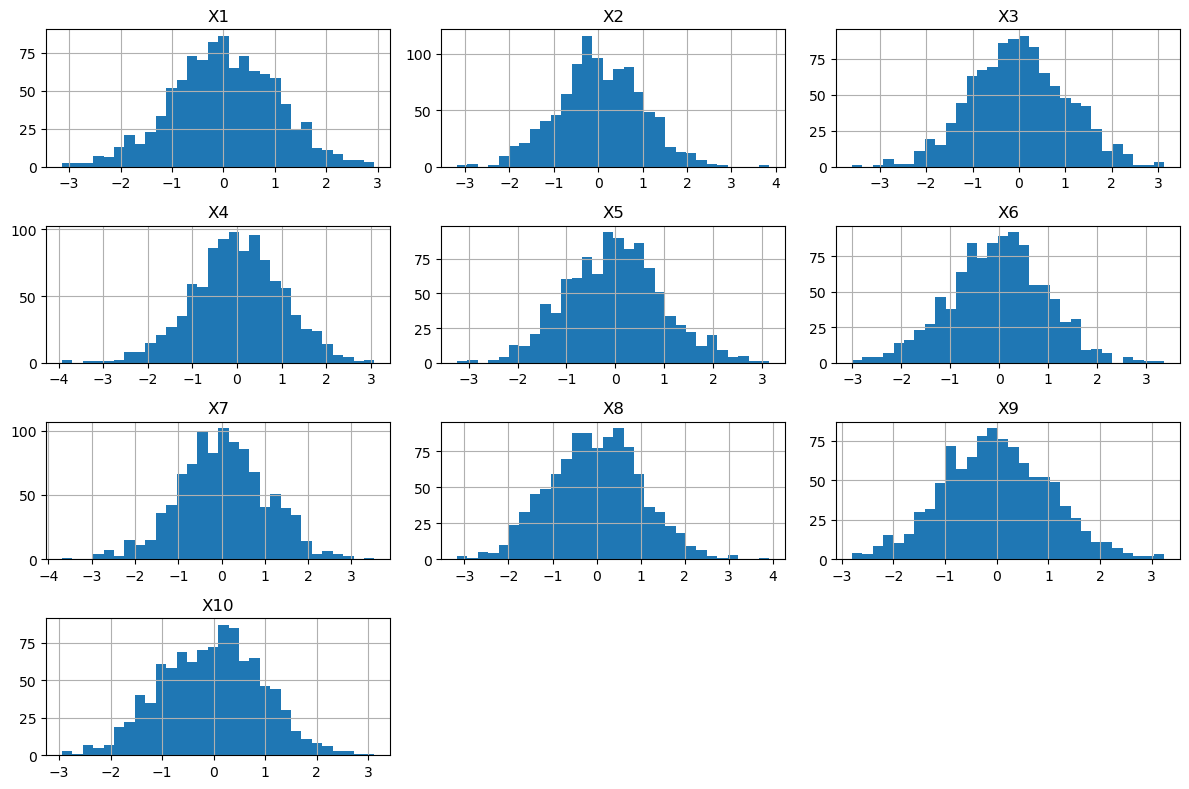

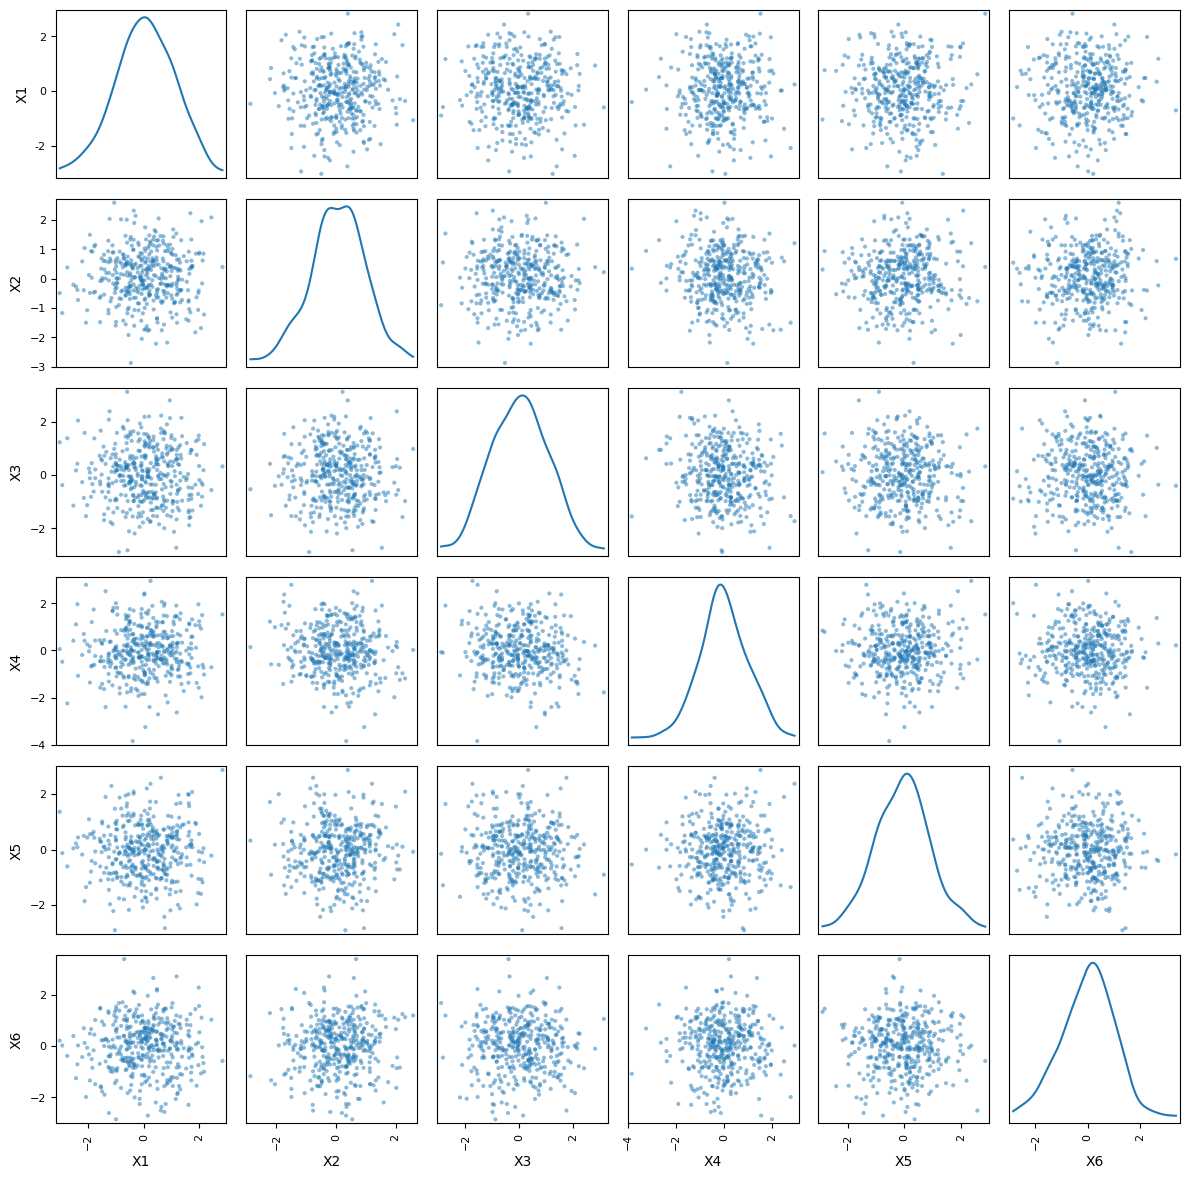

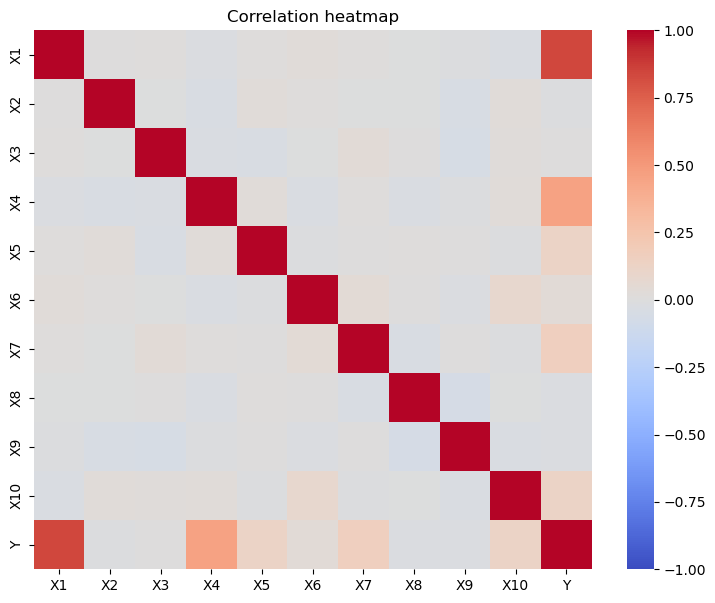

,count,mean,std,min,25%,50%,75%,max
X1,1000.0,0.013622,1.012645,-3.138515,-0.651541,-0.012020,0.721896,2.935658
X2,1000.0,0.038105,0.945284,-3.176704,-0.559290,0.019097,0.687027,3.852731
X3,1000.0,0.005495,1.030962,-3.601085,-0.713176,-0.013284,0.696602,3.137749
X4,1000.0,0.010788,1.005433,-3.922400,-0.616527,0.014006,0.679698,3.076860
X5,1000.0,-0.022542,0.983366,-3.241267,-0.702626,-0.015036,0.613766,3.152057
X6,1000.0,-0.023104,0.986846,-3.007632,-0.650034,-0.003221,0.608861,3.377383
X7,1000.0,0.031292,1.016046,-3.688365,-0.631506,0.007605,0.685621,3.529055
X8,1000.0,-0.029252,1.037024,-3.170426,-0.749592,-0.012086,0.680087,3.926238
X9,1000.0,-0.002689,1.031230,-2.801912,-0.744779,-0.024976,0.683319,3.243093
X10,1000.0,-0.043075,0.983406,-2.943142,-0.750008,-0.001346,0.638310,3.117681


In [5]:
# 히스토그램
import matplotlib.pyplot as plt

df[feature_cols].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()
# Scatterplot matrix

from pandas.plotting import scatter_matrix

sample_df = df.sample(400, random_state=0)  # reduce clutter
_ = scatter_matrix(sample_df[feature_cols[:6]],  # first 6 features to keep it light
                   figsize=(12, 12), diagonal='kde')
plt.tight_layout()
plt.show()

# Correlation matrix

import seaborn as sns

corr = df[feature_cols + ["Y"]].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr, vmin=-1, vmax=1, annot=False, cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()

# 요약 통계량
desc = df[feature_cols + ["Y"]].describe().T
desc

### Q3 `StandardScaler` 로 scaling을 해보자

X 변수들에 대해 `StandarScaler`를 이용하여 표준화를 해보자.
PCA를 하기 전에 스케일링을 한다는 점을 유의하자.

In [6]:
from sklearn.preprocessing import StandardScaler

# 스케일링하기

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols].values)  # ndarray (n_samples, n_features)

# Keep as DataFrame with original column names
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
X_scaled_df["Y"] = df["Y"].values

# Quick check: means ~0, stds ~1 (population std, ddof=0)
print("means:\n", X_scaled_df[feature_cols].mean().round(4))
print("stds :\n", X_scaled_df[feature_cols].std(ddof=0).round(4))

means:
 X1    -0.0
X2    -0.0
X3     0.0
X4     0.0
X5     0.0
X6    -0.0
X7     0.0
X8     0.0
X9    -0.0
X10   -0.0
dtype: float64
stds :
 X1     1.0
X2     1.0
X3     1.0
X4     1.0
X5     1.0
X6     1.0
X7     1.0
X8     1.0
X9     1.0
X10    1.0
dtype: float64


### Q4 `PCA`를 해보자

`PCA` 함수를 이용하여 PCA를 해보자. 또 다음을 해보자.

- PC1 부터 PC10 까지 Scree plot을 그려보자
- PC1과 PC2를 가지고 scatterplot을 그려보자.

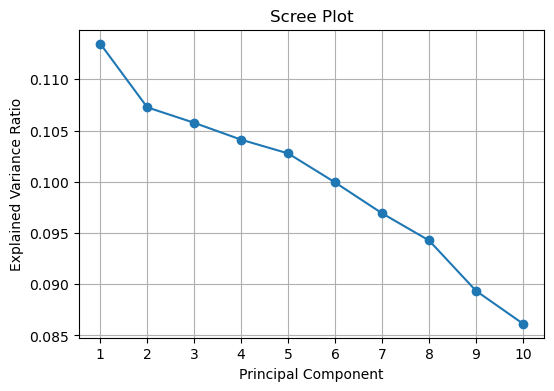

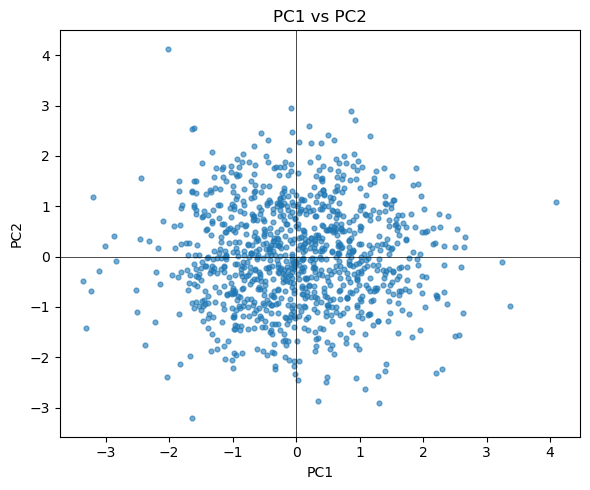

In [7]:
from sklearn.decomposition import PCA

# PCA 계산하기
pca = PCA()
X_pcs = pca.fit_transform(X_scaled)   # scores (PC coordinates)

# Scree plot 그리기
evr = pca.explained_variance_ratio_
plt.figure(figsize=(6,4))
plt.plot(range(1, len(evr)+1), evr, marker="o")
plt.xticks(range(1, len(evr)+1))
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

# PC1 와 PC2 산점도 그리기
plt.figure(figsize=(6,5))
plt.scatter(X_pcs[:, 0], X_pcs[:, 1], s=12, alpha=0.6)
plt.axhline(0, lw=0.5, c="k"); plt.axvline(0, lw=0.5, c="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2")
plt.tight_layout()
plt.show()

### Q5 `train_test_split`을 해보자

Train set과 Test set을 6:4 비율로 나눠보자

In [8]:
from sklearn.model_selection import train_test_split

# train set과 test set 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X_pcs, df["Y"].values,
    test_size=0.4, random_state=42, shuffle=True
)

print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(600, 10) (400, 10) 600 400


###  Q6 Principal Component Regression을 진행해보자.

Q5에서 만든 데이터로부터 다음의 과정으로 문제를 풀어보자.
- Y를 종속변수(`y_train`), `X_train`의 PC1을 종속변수로 하여 Linear Regression을 적합한다.
- `y_pred`과 `y_train`을 비교하여 train error의 MSE를 구한다.
- Principal component을 하나 늘려 Linear regression을 적합한다. 즉 Y에 대해 PC1, PC2으로 Linear Regression을 적합한다.
- 마찬가지로 train error의 MSE를 구한다.
- PC10까지 같은 과정을 반복하고, MSE를 비교한다.



In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# train MSE 저장
max_k = min(10, X_train.shape[1])
mse_train = []
models = []

# 회귀모형 적합

for k in range(1, max_k + 1):
    # use first k principal components
    Xtr_k = X_train[:, :k]
    reg = LinearRegression().fit(Xtr_k, y_train)
    y_pred_tr = reg.predict(Xtr_k)
    mse_k = mean_squared_error(y_train, y_pred_tr)
    mse_train.append(mse_k)
    models.append(reg)

print("Train MSE by k (PC1..PCk):")
for k, m in enumerate(mse_train, 1):
    print(f"k={k:2d} -> {m:.4f}")

Train MSE by k (PC1..PCk):
k= 1 -> 5171.0021
k= 2 -> 4946.2002
k= 3 -> 4945.4430
k= 4 -> 4397.3351
k= 5 -> 3143.9942
k= 6 -> 2133.3852
k= 7 -> 645.5928
k= 8 -> 613.7649
k= 9 -> 117.4551
k=10 -> 107.6325


### Q7 Test error을 계산해보자.

위 과정에서 적합한 모형을 바탕으로 `y_test`을 추정하고 `y_test`와의 MSE를 계산하여 test error을 구해보자.

Test MSE by k:
k= 1 -> 4370.6131
k= 2 -> 4166.1342
k= 3 -> 4154.7466
k= 4 -> 3719.3885
k= 5 -> 2629.3040
k= 6 -> 1856.1787
k= 7 -> 623.7637
k= 8 -> 582.0797
k= 9 -> 85.4028
k=10 -> 80.7116


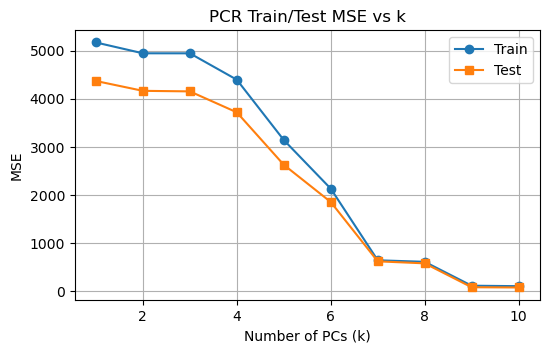

Best k on test = 10 (MSE=80.7116)


In [10]:
# test MSE 저장
mse_test = []

for k in range(1, max_k + 1):
    reg = LinearRegression().fit(X_train[:, :k], y_train)
    y_pred_te = reg.predict(X_test[:, :k])
    mse_k = mean_squared_error(y_test, y_pred_te)
    mse_test.append(mse_k)

print("Test MSE by k:")
for k, m in enumerate(mse_test, 1):
    print(f"k={k:2d} -> {m:.4f}")

# Compare train vs test
plt.figure(figsize=(6,3.5))
plt.plot(range(1, max_k+1), mse_train, marker='o', label="Train")
plt.plot(range(1, max_k+1), mse_test,  marker='s', label="Test")
plt.xlabel("Number of PCs (k)")
plt.ylabel("MSE")
plt.title("PCR Train/Test MSE vs k")
plt.legend()
plt.grid(True)
plt.show()

best_k = int(np.argmin(mse_test) + 1)
print(f"Best k on test = {best_k} (MSE={min(mse_test):.4f})")


## SVM

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC, SVR

- SVC (Classification)
- SVR (Regression)

### 1.1 Hard Margin Classifier

#### Q1.1 Hard Margin Classifier란? : 

Hard Margin Classifier는 SVM의 가장 단순한 형태로, 두 클래스가 완벽하게 직선(혹은 초평면)으로 나눠질 수 있을 때 사용한다. 쉽게 말해, 두 그룹 사이에 ‘도로’를 그리되, 그 도로를 가능한 한 넓게 만들면서도 한쪽 그룹의 점이 도로 안으로 들어오지 않도록 하는 방식이다.

이때 경계선에서 가장 가까운 점들을 **서포트 벡터(Support Vector)**라고 부르며, 이 점들을 기준으로 마진(도로 폭)이 결정된다. Hard Margin 방식은 모든 데이터가 마진 밖에 있어야 하므로, 데이터가 조금이라도 섞이거나 노이즈가 많으면 잘 작동하지 않는다는 한계가 있다. 이런 경우에는 오차를 일부 허용하는 Soft Margin 방법을 사용한다.

In [12]:
# 데이터셋 생성
X = np.array([[1, 2], [2, 3], [3, 3], [6, 6], [7, 8], [8, 8]])
y = np.array([0, 0, 0, 1, 1, 1])

#### Q1.2 위 데이터셋을 2차원의 좌표평면에 시각화해주세요.

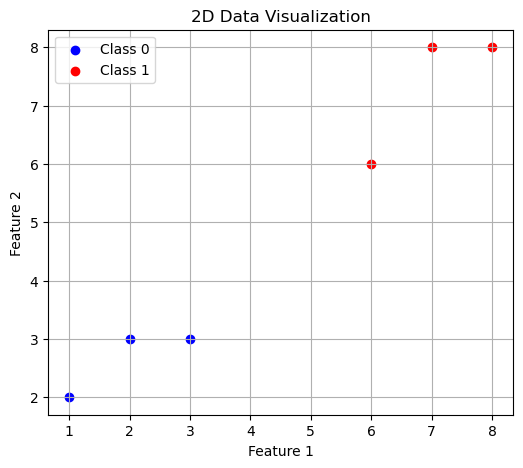

In [13]:
# 시각화
plt.figure(figsize=(6, 5))
plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Data Visualization')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Hard Margin SVM 모델 학습
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

#### Q1.3 하단 w와 b는 모델 학습으로 찾아낸 Wx+b의 계수와 상수항입니다. w와 b를 정의해주세요.

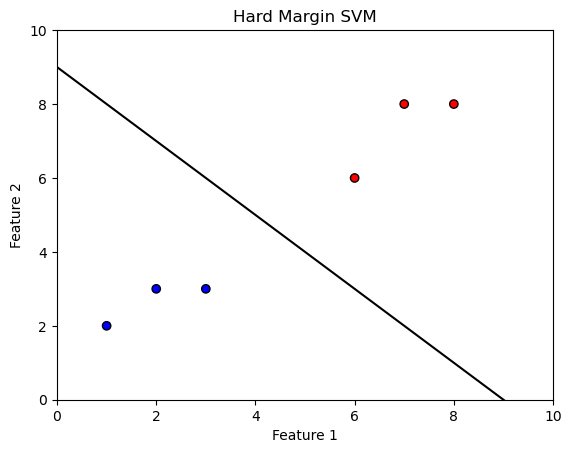

In [15]:
# 결정 경계 시각화
w = model.coef_[0]
b = model.intercept_[0]
x_plot = np.linspace(0, 10, 100)
y_plot = -(w[0] * x_plot + b) / w[1]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
plt.plot(x_plot, y_plot, 'k-')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Hard Margin SVM')
plt.show()

### 1.2 Soft Margin Classifier

#### Q2.1 Soft Margin Classifier란?

Soft Margin Classifier는 SVM이 실제 데이터에서 완벽하게 분리되지 않는 경우(노이즈나 이상치가 있는 경우)에 사용하는 방법이다. Hard Margin처럼 모든 점을 마진 밖에 두는 대신, 일부 점이 마진 안쪽에 들어오거나 심지어 잘못 분류되도록 허용한다.

이때 허용하는 정도는 **패널티 파라미터 
𝐶**로 조절한다. 
C 값이 크면 마진 침범을 강하게 벌주어 Hard Margin에 가까워지고, 
C 값이 작으면 마진 침범을 더 많이 허용하여 마진을 넓히는 쪽을 택한다.

쉽게 말해, Soft Margin은 “도로를 조금 좁히더라도 일부 차들이 도로 위로 살짝 올라올 수 있게 허락하는” 방식이다. 이렇게 하면 약간의 데이터 겹침이나 이상치가 있어도 안정적으로 학습할 수 있다.

#### Q2.2 Soft Margin의 정의를 떠올리며, 노이즈가 추가된 데이터셋을 생성해주세요. (2개 이상 추가 생성 필요)

In [17]:
# 데이터셋 생성 (약간의 노이즈 추가)
X = np.array([[1, 2], [2, 3], [3, 3], [6, 6], [7, 8], [8, 8], [2.5, 5], [5.5, 4.5]])
y = np.array([0, 0, 0, 1, 1, 1, 0, 1])


In [18]:
# Soft Margin SVM 모델 학습
model = SVC(kernel='linear', C=1.0)
model.fit(X, y)

SVC(kernel='linear')

#### Q2.3 마진을 산출해 시각화하고, Support Vector을 찾아주세요.

하단 그림은 예시로, 꼭 똑같이 출력되지 않아도 됩니다.

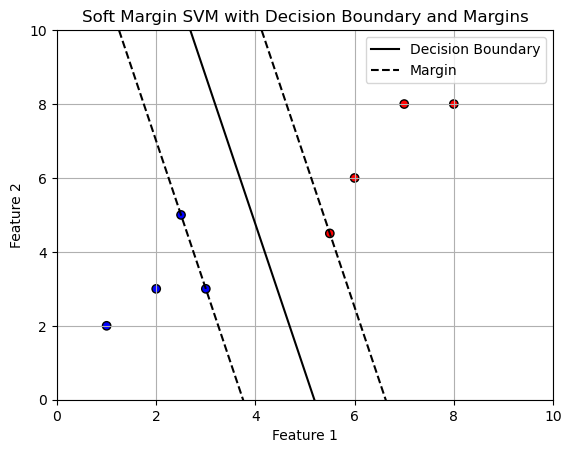

In [19]:
# 결정 경계 시각화
w = model.coef_[0]
b = model.intercept_[0]
x_plot = np.linspace(0, 10, 100)
y_plot = -(w[0] * x_plot + b) / w[1]

# 마진 경계 계산
margin = 1 / np.linalg.norm(w)
y_margin_positive = -(w[0] * x_plot + b - 1) / w[1]
y_margin_negative = -(w[0] * x_plot + b + 1) / w[1]

# 마진 시각화
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
plt.plot(x_plot, y_plot, 'k-', label='Decision Boundary')
plt.plot(x_plot, y_margin_positive, 'k--', label='Margin')
plt.plot(x_plot, y_margin_negative, 'k--')

plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Soft Margin SVM with Decision Boundary and Margins')
plt.legend()
plt.grid(True)
plt.show()

### 1.3 프로젝트 (SVC)

In [20]:
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix

#### **Linear SVC**

In [21]:
iris = load_iris()

X = iris.data[:, :2]
y = iris.target

C = 1
clf = SVC(kernel = "linear", C=C)
clf.fit(X,y)

SVC(C=1, kernel='linear')

In [22]:
y_pred = clf.predict(X) # 학습 데이터의 재예측 (실습용)
confusion_matrix(y, y_pred) # 따라서, 분류 결과가 상당히 정확할 수밖에 없음을 감안해야 함

array([[50,  0,  0],
       [ 0, 38, 12],
       [ 0, 15, 35]], dtype=int64)

#### Q3.1 위 예시처럼, 옵션을 linear로 설정해도 되지만, sklearn의 LinearSVC 함수를 사용해도 구현할 수 있습니다. LinearSVC로 재구현해주세요.

In [26]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score

iris = load_iris()
X = iris.data[:, :2]
y = iris.target

# n_samples > n_features 상황 → primal 풀기: dual=False 권장
lin_svc = make_pipeline(StandardScaler(),
                        LinearSVC(C=1.0, dual=False, random_state=0))
lin_svc.fit(X, y)

y_pred = lin_svc.predict(X)
print("Confusion Matrix (LinearSVC)\n", confusion_matrix(y, y_pred))
print("Accuracy:", round(accuracy_score(y, y_pred), 4))

Confusion Matrix (LinearSVC)
 [[49  1  0]
 [ 1 32 17]
 [ 0 11 39]]
Accuracy: 0.8


#### **Kernal SVC**

#### Q3.2 Kernel SCV - non-linear한 형태의 SVM을 하나 이상 구현해주세요. 동일하게, 학습데이터를 predict하여 confusion matrix를 구해주세요.

In [27]:
# ---------- Kernel SVCs ----------
# 1) linear kernel (reference)
svc_linear = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
svc_linear.fit(X, y)
cm_linear = confusion_matrix(y, svc_linear.predict(X))
acc_linear = accuracy_score(y, svc_linear.predict(X))
print("Confusion Matrix (SVC linear)\n", cm_linear)
print("Accuracy (linear):", round(acc_linear, 4))

# 2) RBF kernel (non-linear)
svc_rbf = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1.0, gamma="scale", random_state=0))
svc_rbf.fit(X, y)
cm_rbf = confusion_matrix(y, svc_rbf.predict(X))
acc_rbf = accuracy_score(y, svc_rbf.predict(X))
print("\nConfusion Matrix (SVC RBF)\n", cm_rbf)
print("Accuracy (RBF):", round(acc_rbf, 4))

# 3) Polynomial kernel (degree=3) — optional another non-linear model
svc_poly3 = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, C=1.0, gamma="scale", coef0=1.0))
svc_poly3.fit(X, y)
cm_poly = confusion_matrix(y, svc_poly3.predict(X))
acc_poly = accuracy_score(y, svc_poly3.predict(X))
print("\nConfusion Matrix (SVC poly deg=3)\n", cm_poly)
print("Accuracy (poly deg=3):", round(acc_poly, 4))

Confusion Matrix (SVC linear)
 [[49  1  0]
 [ 0 38 12]
 [ 0 15 35]]
Accuracy (linear): 0.8133

Confusion Matrix (SVC RBF)
 [[49  1  0]
 [ 0 36 14]
 [ 0 12 38]]
Accuracy (RBF): 0.82

Confusion Matrix (SVC poly deg=3)
 [[50  0  0]
 [ 0 37 13]
 [ 0 13 37]]
Accuracy (poly deg=3): 0.8267


#### 시각화

#### Q3.3 아래 예시 plot처럼, linear model과 non-linear 모델의 시각화 결과를 출력해주세요.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


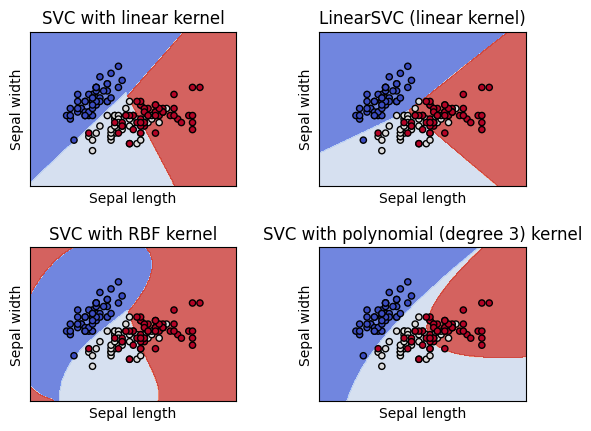

In [ ]:
plt.show()

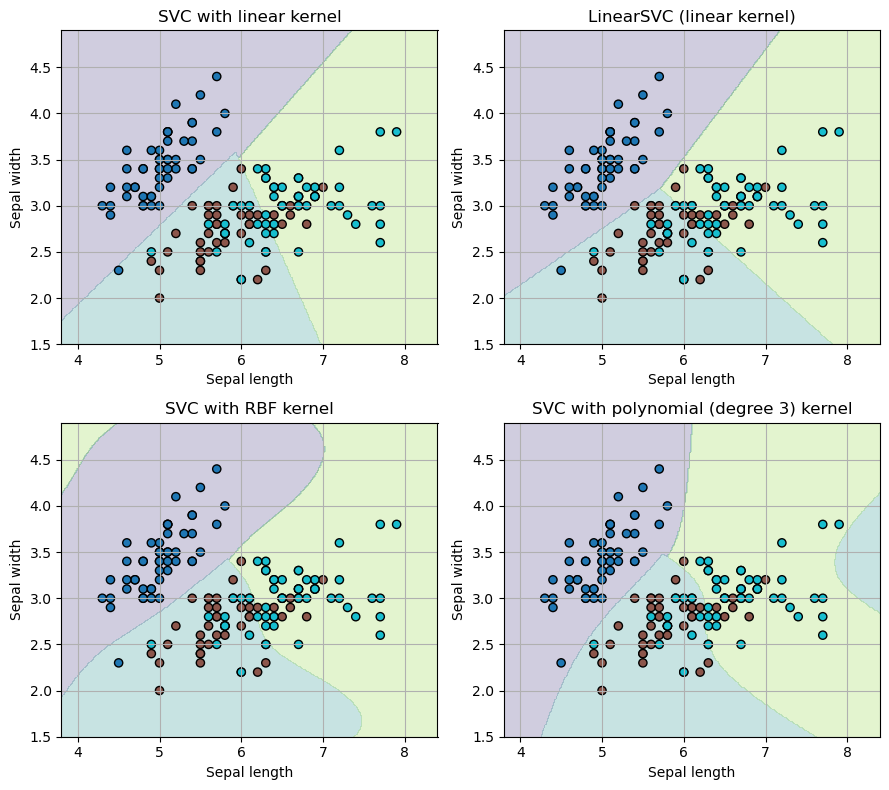

In [28]:
# 모델 정의
svc_linear = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
lin_svc     = make_pipeline(StandardScaler(), LinearSVC(C=1.0, dual=False, random_state=0))
svc_rbf     = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1.0, gamma="scale"))
svc_poly3   = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, C=1.0, gamma="scale", coef0=1.0))

# 모델 학습
svc_linear.fit(X, y)
lin_svc.fit(X, y)
svc_rbf.fit(X, y)
svc_poly3.fit(X, y)

# 결정 경계 시각화 함수
def plot_decision(ax, model, X, y, title):
    x0, x1 = X[:, 0], X[:, 1]
    x_min, x_max = x0.min() - 0.5, x0.max() + 0.5
    y_min, y_max = x1.min() - 0.5, x1.max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25, levels=np.arange(y.max()+2)-0.5)
    ax.scatter(x0, x1, c=y, edgecolors="k", cmap="tab10", s=35)
    ax.set_xlabel("Sepal length")
    ax.set_ylabel("Sepal width")
    ax.set_title(title)
    ax.grid(True)

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(9, 8))
plot_decision(axes[0, 0], svc_linear, X, y, "SVC with linear kernel")
plot_decision(axes[0, 1], lin_svc,     X, y, "LinearSVC (linear kernel)")
plot_decision(axes[1, 0], svc_rbf,     X, y, "SVC with RBF kernel")
plot_decision(axes[1, 1], svc_poly3,   X, y, "SVC with polynomial (degree 3) kernel")
plt.tight_layout()
plt.show()